In [7]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# 시각화 셋팅
plt.rc('font',size=4)
plt.rc('axes',labelsize=4, titlesize=14)
plt.rc('legend',fontsize=14)
plt.rc('xtick',labelsize=14); plt.rc('ytick',labelsize=14)

In [14]:
from sklearn.datasets import load_sample_images
images = load_sample_images()['images']
np.array(images).shape

(2, 427, 640, 3)

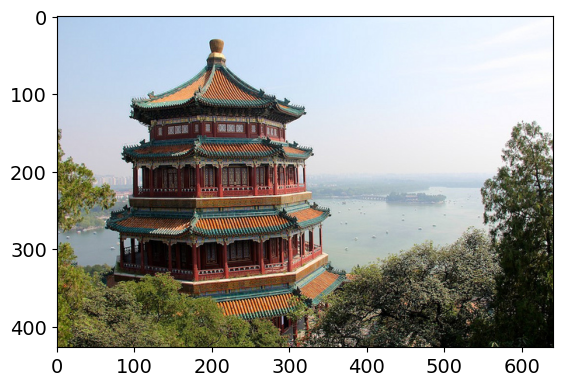

In [15]:
plt.imshow(images[0])

(2, 70, 120, 3)


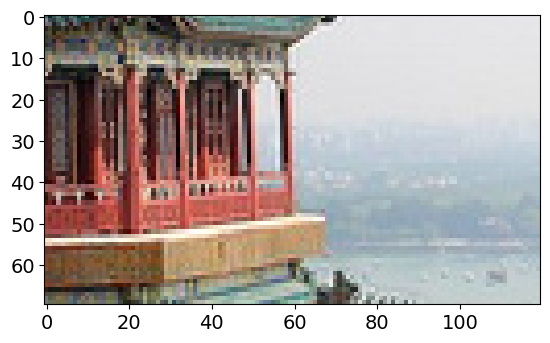

In [22]:
images = load_sample_images()['images']
images = tf.keras.layers.CenterCrop(height=70, width=120)(images)
images = tf.keras.layers.Rescaling(scale=1/255)(images)
print(images.shape)
plt.imshow(images[0])

In [27]:
tf.random.set_seed(42)
# (2, 70, 120, 3)
# 스트라이드 1 패딩은 없고... kernel_size-1 한 값으로 shape를 빼준다.
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7)
fmaps = conv_layer(images)
fmaps.shape

TensorShape([2, 64, 114, 32])

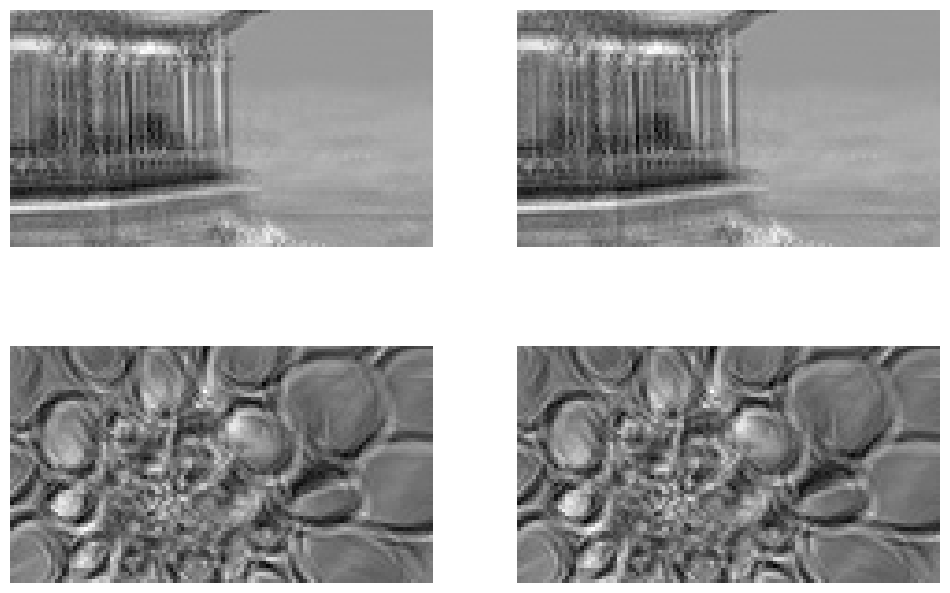

In [33]:
# 채널을이용해서 채널개수를 늘려주면... conv학습할때 다양한 패턴을 학습
plt.figure(figsize=(12,8))
for i in range(4):
  plt.subplot(2,2,i+1)
  plt.imshow(fmaps[i//2,:,:,i//2],cmap='gray_r')
  plt.axis('off')
plt.show()

In [34]:
# 패팅... 제로패팅  스트라이드가 1이면.... 크기는 변동 없다.
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7,padding='same')   # 제로패딩 추가
fmaps = conv_layer(images)
fmaps.shape

TensorShape([2, 70, 120, 32])

In [45]:
# padding='same' 이면 strides으로 나눈다. 나눠지지 않으면 나머지가 0이되도록 연산
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7,padding='same',strides=2)   # 제로패딩 추가
fmaps = conv_layer(images)
fmaps.shape

TensorShape([2, 35, 60, 32])

In [44]:
# 패딩이 valid 여부에 따라서 shape 형태가 달라진다.
def conv_output_size(input_size, kernel_size, stride=1, padding ='valid'):
  if padding == 'valid':
    z = input_size - kernel_size + 1
    output_size = z // stride
    num_ignored = z % stride
    return output_size, num_ignored
  else:
    output_size =  (input_size -1) // stride + 1
    num_padded = (output_size - 1) * stride + kernel_size - input_size
    return output_size, num_padded
conv_output_size(np.array([70,120]),kernel_size=7, stride=2,padding='same'        )

(array([35, 60]), array([5, 5]))

In [47]:
# 가중치 7, 7, 3, 32 --> 7, 7 필터의 크기, 3 입력데이터의 채널수 , 32 필터의 개수
kernels, bias = conv_layer.weights
kernels, bias

(<KerasVariable shape=(7, 7, 3, 32), dtype=float32, path=conv2d_14/kernel>,
 <KerasVariable shape=(32,), dtype=float32, path=conv2d_14/bias>)

In [49]:
# 폴링 - 케라스로 구현

In [60]:
max_pool = tf.keras.layers.AveragePooling2D(pool_size=2, strides=2)
output = max_pool(images)
print(images.shape)

(2, 70, 120, 3)


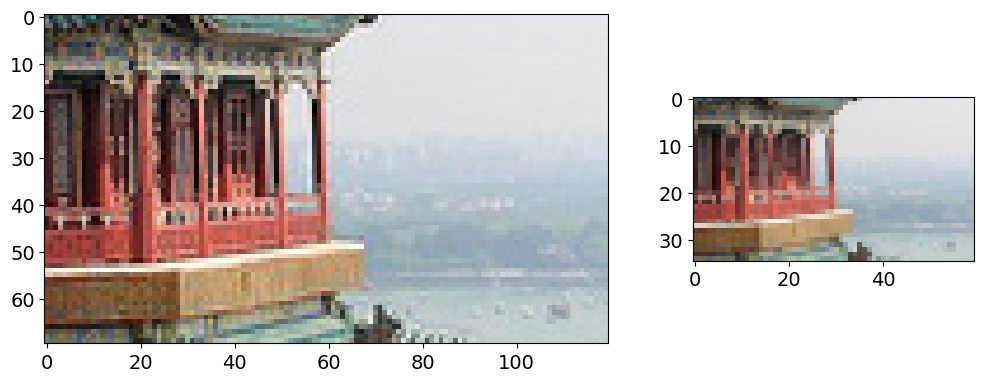

In [61]:
import matplotlib as mpl
fig = plt.figure(figsize=(12,8))
gs = mpl.gridspec.GridSpec(1,2,width_ratios=(2,1))
fig.add_subplot(gs[0,0])
plt.imshow(images[0])
fig.add_subplot(gs[0,1])
plt.imshow(output[0])

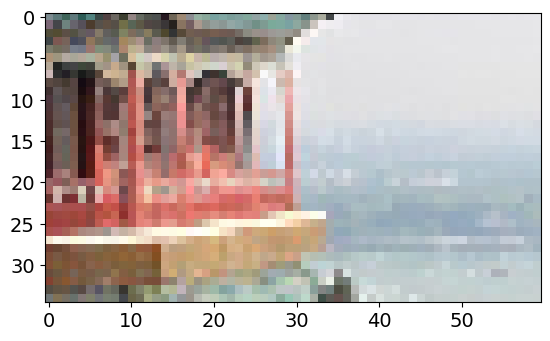

In [54]:
plt.imshow(output[0])

In [62]:
# CNN
# mnist 분류기

In [70]:
(x_train_f,y_train_f),(x_test,y_test) = tf.keras.datasets.mnist.load_data()
# 채널정보를 추가하고 그리고 정규화
x_train_f = np.expand_dims(x_train_f,axis=-1) / 255.
x_test = np.expand_dims(x_test,axis=-1) / 255.
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train_f,y_train_f,test_size=0.1)
x_train.shape

(54000, 28, 28, 1)

In [69]:
# 재현성 보장 : 랜덤시드를 고정시켜서 데이터의 변화에따른 성능변화를 금지시켜서 오로지 모델선택에 관해 일관성을 유지하는 방법
tf.random.set_seed(42)

In [71]:
from functools import partial
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, padding='same', activation='relu')
model = tf.keras.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=x_train.shape[1:]), # [28,28,1]
    tf.keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=10, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [73]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val))
scores = model.evaluate(x_test, y_test)
# 예측
x_new = x_test[:10]
y_pred = model.predict(x_new)

스킵커넥션

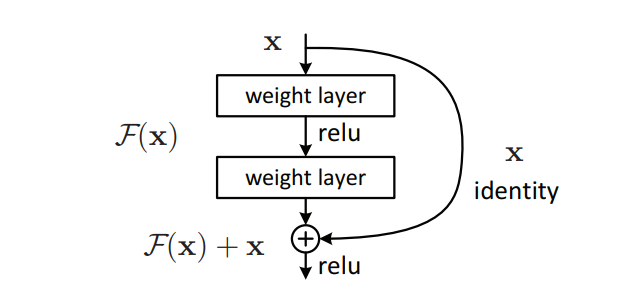

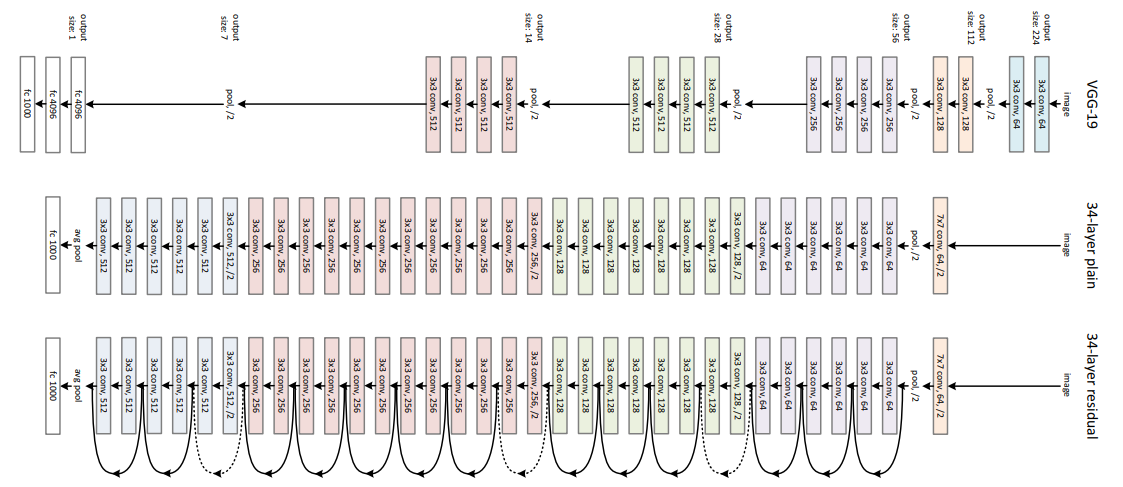

In [82]:
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, padding="same",strides=1,use_bias=False)

In [85]:
class ResidualBlock(tf.keras.layers.Layer):
  def __init__(self,filters,strides=1,activation='relu', **kwargs) -> None:
    super().__init__(**kwargs)
    self.activation = tf.keras.activations.get(activation)
    self.main_layers = [
        DefaultConv2D(filters,strides=strides),
        tf.keras.layers.BatchNormalization(),
        self.activation,
        DefaultConv2D(filters),
        tf.keras.layers.BatchNormalization()
    ]
    # residualblock skip connection
    self.skip_layers = []
    # 스트라이드가 1보다 크면 입력과 출력의 차원이 다르므로 스킵커넥션에서 맞춰주기 위해서 1x1합성곱과 배치정규화를 추가
    if strides > 1:
      self.skip_layers = [
          DefaultConv2D(filters,kernel_size=1,strides=strides),
          tf.keras.layers.BatchNormalization()
      ]
  def call(self, inputs):
    z = inputs  # 입력을 z에 저장
    for layer in self.main_layers:  # conv batch 차례대로 통과
      z = layer(z)
    skip_z = inputs  # skip_z 원본 입력을 저장
    for layer in self.skip_layers: # 스킵레이어를 통과시켜서 크기를 맞춰준다
      skip_z = layer(skip_z)
    return self.activation(z + skip_z)


In [87]:
# ResNet(residual network)
model = tf.keras.Sequential([
    DefaultConv2D(64,kernel_size=7,strides=2,input_shape=[224,224,3]), # 다운샘플링
    tf.keras.layers.BatchNormalization(), # 속도향상 불안정한 학습을 방지
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=3,strides=2,padding='same')
])
# Residual Block 추가
# 64 필터의 블럭을 3
# 128 필터의 블럭을 4
# 256 필터의 블럭을 6
# 512 필터의 블럭을 3
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
  strides = 1 if filters == prev_filters else 2
  model.add(ResidualBlock(filters,strides=strides))
  prev_filters = filters
# 컨볼류션의 완성
# 분류기 FC
model.add(tf.keras.layers.GlobalAvgPool2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(10,activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


<Sequential name=sequential_3, built=True>

In [88]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_61 (Conv2D)                   │ (None, 112, 112, 64)        │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_39               │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block_17 (ResidualBlock)    │ (None, 56, 56, 64)          │          74,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block_18 (ResidualBlock)    │ (None, 56, 56, 64)          │          74,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block_19 (ResidualBlock)    │ (None, 56, 56, 64)          │          74,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block_20 (ResidualBlock)    │ (None, 28, 28, 128)         │         230,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block_21 (ResidualBlock)    │ (None, 28, 28, 128)         │         295,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block_22 (ResidualBlock)    │ (None, 28, 28, 128)         │         295,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block_23 (ResidualBlock)    │ (None, 28, 28, 128)         │         295,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block_24 (ResidualBlock)    │ (None, 14, 14, 256)         │         920,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block_25 (ResidualBlock)    │ (None, 14, 14, 256)         │       1,181,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block_26 (ResidualBlock)    │ (None, 14, 14, 256)         │       1,181,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block_27 (ResidualBlock)    │ (None, 14, 14, 256)         │       1,181,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block_28 (ResidualBlock)    │ (None, 14, 14, 256)         │       1,181,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block_29 (ResidualBlock)    │ (None, 14, 14, 256)         │       1,181,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block_30 (ResidualBlock)    │ (None, 7, 7, 512)           │       3,676,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block_31 (ResidualBlock)    │ (None, 7, 7, 512)           │       4,722,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_block_32 (ResidualBlock)    │ (None, 7, 7, 512)           │       4,722,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 512)                 │              

 Total params: 21,306,826 (81.28 MB)

 Trainable params: 21,289,802 (81.21 MB)

 Non-trainable params: 17,024 (66.50 KB)

In [89]:
# 케라스에서 제공하는 전이학습모델

In [90]:
model = tf.keras.applications.resnet50.ResNet50(weights='imagenet')

102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [100]:
image = load_sample_images()['images']
# 사이지를 ResNEt50 입력 사이즈에 맞게 재 조정 224 224
image_resize = tf.keras.layers.Resizing(224,224,crop_to_aspect_ratio=True)(np.array(image))
input = tf.keras.applications.resnet50.preprocess_input(image_resize)
pred = model.predict(input)
pred.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


(2, 1000)

In [101]:
# decode_predictions 예측 결가를  클래스id 클래스이름,확률로 변환
top_k = tf.keras.applications.resnet50.decode_predictions(pred,top=3)
# 이미지별 예측결과를 출력
for image_index in range(len(image)):
  print("image #{}".format(image_index))
  for classid,name,prob in top_k[image_index]:
    print("  {} - {:12s} {:.2f}%".format(classid,name,prob*100))
  print()

35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
image #0
  n03598930 - jigsaw_puzzle 38.05%
  n02782093 - balloon      14.30%
  n03877845 - palace       4.83%

image #1
  n04209133 - shower_cap   18.77%
  n02782093 - balloon      12.99%
  n09229709 - bubble       11.91%



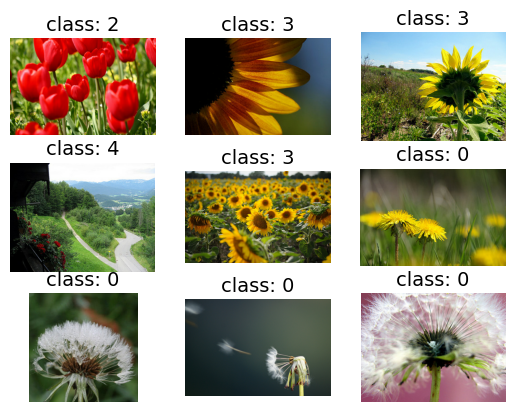

In [117]:
import tensorflow_datasets as tfds
test_set_raw, valid_set_raw, train_set_raw = tfds.load('tf_flowers',
                          split=['train[:10%]', 'train[10%:25%]','train[25%:]'],
                          as_supervised=True,
                          )
for idx,(image, label) in enumerate(test_set_raw.take(9)):
  plt.subplot(3,3,idx+1)
  plt.imshow(image)
  plt.title('class: {}'.format(label.numpy()))
  plt.axis('off')
plt.show()



In [122]:
# 전이학습중에서 입력 레이어가 있는 모델은 학습하고자하는 사이를 입력으로 하는 층으로 대처하기 위해서
# include_top = False
tf.random.set_seed(42)
base_model = tf.keras.applications.xception.Xception(weights='imagenet',include_top=False)
base_model.summary()

Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, None, None, 3)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, None, None, 32) │            864 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, None, None, 32) │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, None, None, 32) │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, None, None, 64) │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, None, None, 64) │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, None, None, 64) │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, None, None,     │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, None, None,     │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, None, None,     │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, None, None,     │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, None, None,     │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_109 (Conv2D)       │ (None, None, None,     │          8,192 │ block1_conv2_act[0][0] │
│                           │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, None, None,     │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)       

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 20,806,952 (79.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [124]:
#train_set_raw 낱개로 데이터가 존재하는 구조
# 동일한 이미지 크기로 묶어준다.
preprocess = tf.keras.Sequential([
    tf.keras.layers.Resizing(224,224,crop_to_aspect_ratio=True),
    tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input)
])
train_set = train_set_raw.map(lambda x,y : (preprocess(x),y))
train_set = train_set.shuffle(1000).batch(32).prefetch(1)
valid_set = valid_set_raw.map(lambda x,y : (preprocess(x),y)).batch(32).prefetch(1)
test_set = test_set_raw.map(lambda x,y : (preprocess(x),y)).batch(32).prefetch(1)

In [ ]:
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(5,activation='softmax')(avg)
model = tf.keras.Model(inputs=base_model.input,outputs=output)
# 가중치 고정(파인튜닝)
for layer in base_model.layers:
  layer.trainable = False
# 훈련 , 분류여부 확인
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='sparse_categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
history = model.fit(train_set, validation_data=valid_set, epochs=3)

Epoch 1/3
 6/86 ━━━━━━━━━━━━━━━━━━━━ 9:53 7s/step - accuracy: 0.5244 - loss: 1.1834